
## Detailed article explaination
The detailed code explanation for this article is available at the following link:

https://www.daniweb.com/programming/computer-science/tutorials/541123/stock-price-prediction-using-1d-cnn-in-tensorflow-keras

For my other articles for Daniweb.com, please see this link:

https://www.daniweb.com/members/1235222/usmanmalik57


## Importing Required Libraries and Datasets

In [29]:
import yfinance as yf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
# Define the ticker symbol for the stock
ticker_symbol = "GOOG"  # Example: Apple Inc.

# Define the start and end dates for the historical data
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=5 * 365)  # 5 years ago

# Retrieve historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the historical data as a Pandas DataFrame
print(data.shape)
data.tail()

[*********************100%%**********************]  1 of 1 completed
(1258, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-27,137.570007,139.630005,137.539993,138.050003,138.050003,17886400
2023-11-28,137.630005,138.660004,137.039993,138.619995,138.619995,17046900
2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700
2023-11-30,136.399994,136.960007,132.789993,133.919998,133.919998,29913500
2023-12-01,133.320007,133.500000,132.151993,133.320007,133.320007,24258400


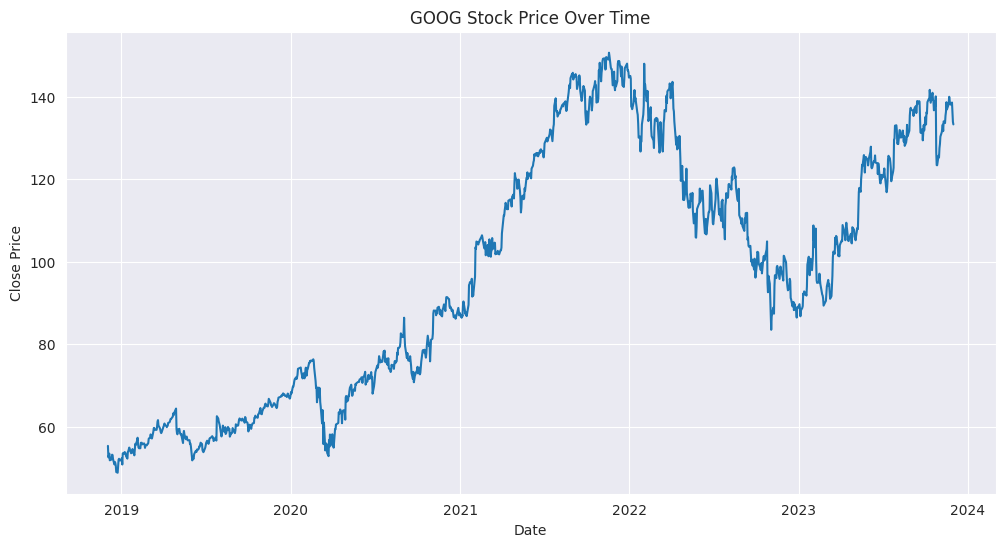

In [31]:
plt.figure(figsize=(12, 6))
sns.set_style('darkgrid')
sns.lineplot(x=data.index, y=data['Close'])

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{ticker_symbol} Stock Price Over Time')

# Show the plot
plt.show()

## Data Preprocessing

In [32]:
# Divide the dataset into training and test sets

# Get the number of records in the DataFrame
total_records = len(data)

# Number of records to keep in the training set
train_size = total_records - 60

# Create the training set
train_data = data.iloc[:train_size]

# Create the test set
test_data = data.iloc[train_size:]

print(train_data.shape, test_data.shape)


(1198, 6) (60, 6)


In [33]:
train_data = train_data['Close'].values.reshape(-1,1)
test_data = test_data['Close'].values.reshape(-1,1)

print(train_data.shape, test_data.shape)


(1198, 1) (60, 1)


In [34]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_normalized = scaler.fit_transform(train_data)
test_normalized = scaler.transform(test_data)

In [35]:
# Create sequences for X_train and y_train
def create_train_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)


# Define sequence length
sequence_length = 60

In [36]:
X_train, y_train = create_train_sequences(train_normalized , sequence_length)

# Print the shapes of X_train and y_train
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1138, 60, 1)
y_train shape: (1138, 1)


In [37]:
# Create X_test and y_test
def create_sequences_test(train_data, test_data):

  X_test, y_test = [], []

  for i in range(len(test_data)):
      # Use the last 60 days of the training data as the first input
      if i == 0:
          X_test.append(train_data[-sequence_length:].flatten())
      # Use the previous input and append the next day of the test data
      else:
          X_test.append(np.append(X_test[i-1][1:], test_data[i-1]))
      # Use the corresponding day of the test data as the output
      y_test.append(test_data[i])

  return np.array(X_test), np.array(y_test)

# Use the function to create X_test and y_test
X_test, y_test = create_sequences_test(train_normalized, test_normalized)

# Print the corrected shapes of X_test and y_test
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (60, 60)
y_test shape: (60, 1)


## Training the Model

In [38]:
# Input layer
input_layer = Input(shape=(sequence_length , 1))

# First Conv1D layer with 32 filters and a kernel size of 3
conv1d_1 = Conv1D(32, 2, activation='relu', padding = 'same')(input_layer)
maxpooling_1 = MaxPooling1D(pool_size=2)(conv1d_1)
dropout_1 = Dropout(0.2)(maxpooling_1)

# Second Conv1D layer with 64 filters and a kernel size of 3
conv1d_2 = Conv1D(64, 2, activation='relu', padding = 'same')(dropout_1)
maxpooling_2 = MaxPooling1D(pool_size=2)(conv1d_2)
dropout_2 = Dropout(0.2)(maxpooling_2)

# Third Conv1D layer with 128 filters and a kernel size of 3
conv1d_3 = Conv1D(128, 2, activation='relu', padding = 'same')(dropout_2)
maxpooling_3 = MaxPooling1D(pool_size=2)(conv1d_3)
dropout_3 = Dropout(0.2)(maxpooling_3)

# Flatten layer
flatten = Flatten()(dropout_3)

# Dense layers
dense_1 = Dense(200, activation='relu')(flatten)

# Dense layers
dense_2 = Dense(100, activation='relu')(flatten)

# Output layer with a single neuron
output_layer = Dense(1, activation='linear')(dense_2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 32)            96        
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 32)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 30, 32)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 30, 64)            4160      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 15, 64)            0         
 g1D)                                                      

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=500,
    validation_split=0.2,  # 20% of the data for validation
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
29/29 [==============================] - 2s 10ms/step - loss: 0.0267 - val_loss: 0.0814
Epoch 2/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0585
Epoch 3/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0538
Epoch 4/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0553
Epoch 5/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0649
Epoch 6/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0626
Epoch 7/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0499
Epoch 8/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0459
Epoch 9/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0493
Epoch 10/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0558
Epoch 11

## Evaluating the Model

In [40]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Print the values
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

2/2 [==============================] - 0s 3ms/step
Mean Squared Error (MSE): 0.012350280587115948
Mean Absolute Error (MAE): 0.108626057535219


In [41]:
y_test = scaler.inverse_transform(y_test)
y_true = scaler.inverse_transform(predictions)

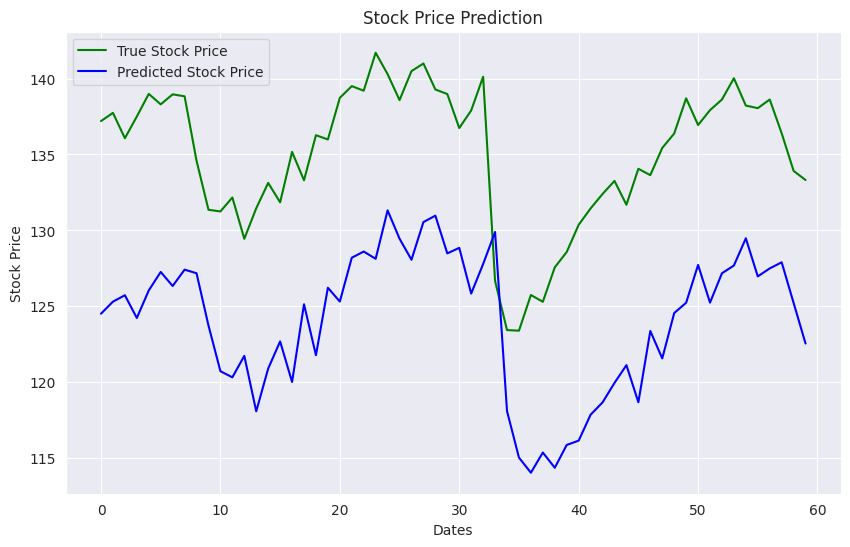

In [42]:
plt.figure(figsize=(10,6))
plt.plot(y_test, color='green', label='True Stock Price')
plt.plot(y_true, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Dates')
plt.ylabel('Stock Price')
plt.legend()
plt.show()